In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data

In [7]:
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)

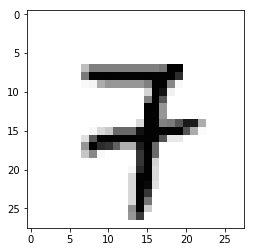

In [8]:
'''sample data'''

plt.imshow(mnist.train.images[14].reshape(28,28), cmap='Greys')

In [9]:
'''generator neural network'''

def generator(z, reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        h1 = tf.layers.dense(inputs=z,units=128)
        alpha = 0.01
        h1 = tf.maximum(alpha*h1,h1)
        h2 = tf.layers.dense(inputs=h1,units=128)
        h2 = tf.maximum(alpha*h2,h2)

        opt = tf.layers.dense(h2,units=784,activation=tf.nn.tanh)

        return opt

In [10]:
'''discriminator neural network'''

def discriminator(z,reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        h1 = tf.layers.dense(inputs=z,units=128)
        alpha = 0.01
        h1 = tf.maximum(alpha*h1,h1)
        h2 = tf.layers.dense(inputs=h1,units=128)
        h2 = tf.maximum(alpha*h2,h2)

        logits = tf.layers.dense(h2,units=1)
        opt = tf.sigmoid(logits)
        return opt, logits

In [11]:
'''placeholders for discriminator'''

real_image = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32, shape=[None, 100])

g = generator(z)
opt_real, logits_real = discriminator(real_image)

opt_fake,logits_fake = discriminator(g,reuse=True)

In [14]:
# losses

def loss_fn(logits_, labels_):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_, labels=labels_))


In [15]:
'''loss functions for generator and discriminator '''

d_real_loss = loss_fn(logits_real,tf.ones_like(logits_real)*0.9)
d_fake_loss = loss_fn(logits_fake,tf.zeros_like(logits_real))

d_loss = d_real_loss+d_fake_loss
g_loss = loss_fn(logits_fake,tf.ones_like(logits_fake))
l_r = 0.001

In [17]:
t_vars = tf.trainable_variables()

d_vars=[var for var in t_vars if 'dis' in var.name]
g_vars=[var for var in t_vars if 'gen' in var.name]

In [18]:
'''Optimizers (Adam optimizer)'''

d_train = tf.train.AdamOptimizer(learning_rate=l_r).minimize(d_loss,var_list = d_vars)
g_train = tf.train.AdamOptimizer(learning_rate=l_r).minimize(g_loss,var_list = g_vars)

In [22]:
batch_size  = 100
epochs = 30
samples=[]

In [1]:
''' Training Session '''

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        print('epoch number', i)
        nb = mnist.train.num_examples//batch_size
        for i in range(nb):
            batch = mnist.train.next_batch(batch_size)
            bi = batch[0].reshape((batch_size,784))
            bi = bi*2-1
            
            bz = np.random.uniform(-1,1,size=(batch_size,100))
            
            _ =  sess.run(d_train,feed_dict={real_image:bi,z:bz})
            _ = sess.run(g_train,feed_dict={z:bz})
            
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True), feed_dict={z:sample_z})
        
        samples.append(gen_sample)

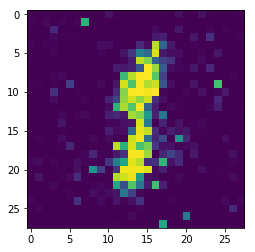

In [25]:
# regenrated image from a random input data

plt.imshow(samples[20].reshape(28,28))

In [ ]:
new_samples=[]
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    